In [ ]:
# Indexing

# Note: if we use a multimodal model such as CLIP/CLIPSeg, we can directly embed the images.
# Additionally, we do not need to capture sentence embeddings, as the CLIP model can directly embed the prompts.
# However, I have found in practice that BEiT is a more accurate image model with similar runtime.

BATCH_SIZE = 2               # Small batch sizes work best locally. Increase with more GPUs.
MAX_FILES = 1000             # float("inf") for the whole dataset
MIN_SEG_SIZE = 30            # Minimum number of pixels a region must occupy to obtain a label
SEGMENTATION_MODEL = "microsoft/beit-base-finetuned-ade-640-640"

import json
import logging
import os

import chromadb
import numpy as np
from datasets import Dataset
from tqdm import tqdm
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

chroma = chromadb.PersistentClient("tags.db")
collection = chroma.get_or_create_collection("tagged_images")
existing_count = collection.count()
print(f"Loaded collection of {existing_count} documents.")

files = [f"images/{img}" for img in os.listdir("images")]
num_files = min(MAX_FILES, len(files))

files = files[0:num_files]

# Because we segment, we can also index the individual regions of interest rather than the whole image.
segmenter = pipeline("image-segmentation", model=SEGMENTATION_MODEL, device="cuda",
                     batch_size=BATCH_SIZE, framework="pt", return_tensors="pt")

# A Dataset is faster than a list of file literals, with built in batching.
segmented_images = segmenter(KeyDataset(Dataset.from_dict({"file": files}), "file"))

def filter_regions(segmented):
    """Filters out regions that are too small to be interesting, according to the MIN_SEG_SIZE parameter."""
    for obj in segmented:
        mask = np.array(obj["mask"])
        mask_pixels = np.count_nonzero(mask)
        if mask_pixels >= MIN_SEG_SIZE:
            yield obj
        else:
            logging.debug(f"Discarding {obj['label']} because it is too small ({mask_pixels} pixels)")

def save_masks(input_filename, segmented):
    """Saves the masks to disk and replaces the in-memory representation with the filename."""
    for obj in segmented:
        base_filename = os.path.splitext(os.path.basename(input_filename))[0]
        mask_filename = f"masks/{obj['label']}_{base_filename}.png"
        obj["mask"].save(mask_filename)
        obj["mask"] = mask_filename

for filename, segmented_img in zip(files, tqdm(segmented_images, total=num_files)):
    try:
        filtered = list(filter_regions(segmented_img))
        img_labels = [obj["label"] for obj in filtered]
        save_masks(filename, filtered)
        if not img_labels:
            continue  # Nothing interesting found
        
        label = " ".join(img_labels)  # This is not optimal, but works given time constraints.
        metadata = {"segmentation": json.dumps(filtered)}

        # Computes an implicit document embedding using all-MiniLM-L6-v2
        # Any SentenceTransformers embedding can be passed.
        # (manually doing this is simply SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2').encode(prompts, convert_to_tensor=True))
        collection.upsert(ids=filename, documents=label, metadatas=metadata)
    except Exception as e:
        logging.error(f"Error indexing {filename}: {e}")

print(f"Processed {num_files} images. Collection now has {collection.count()} documents.")

Loaded collection: Elapsed time is 0.003259 seconds.
Query: Elapsed time is 0.040203 seconds.
10 results found.


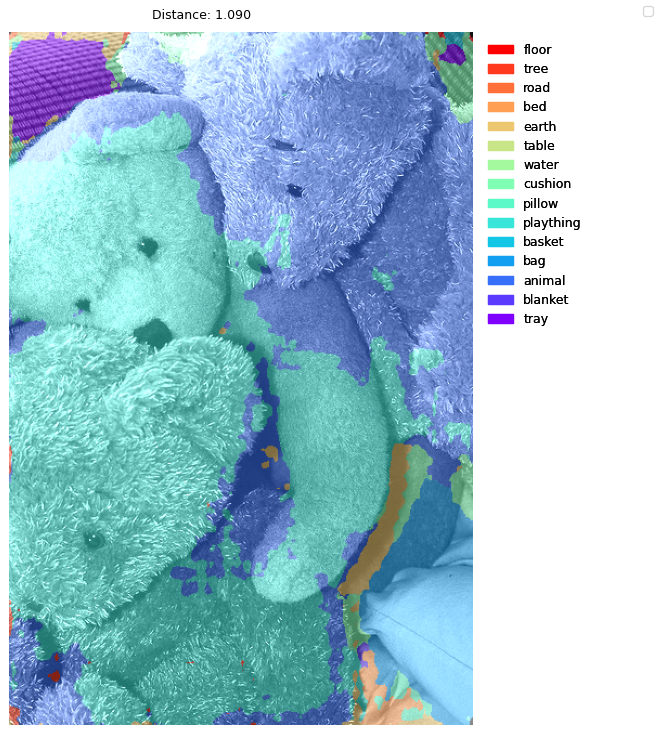

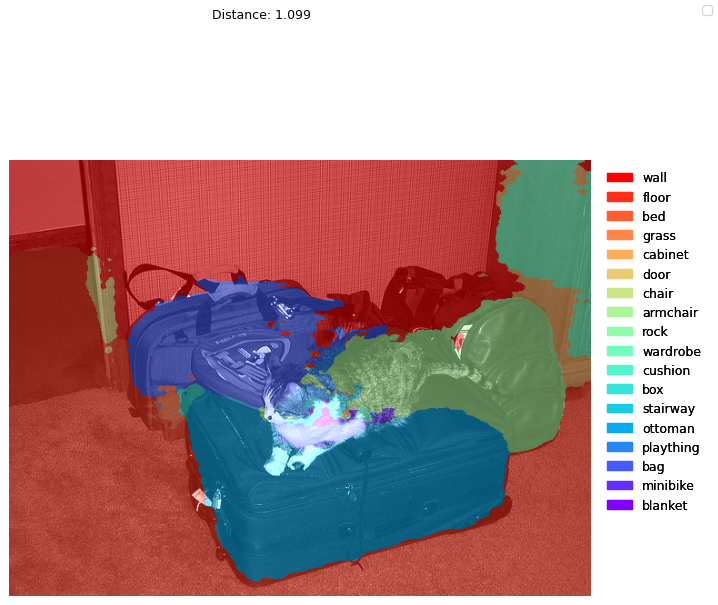

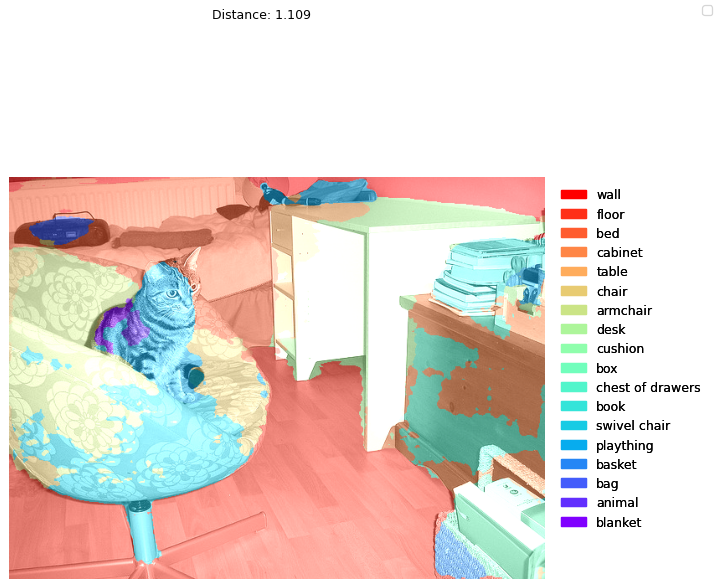

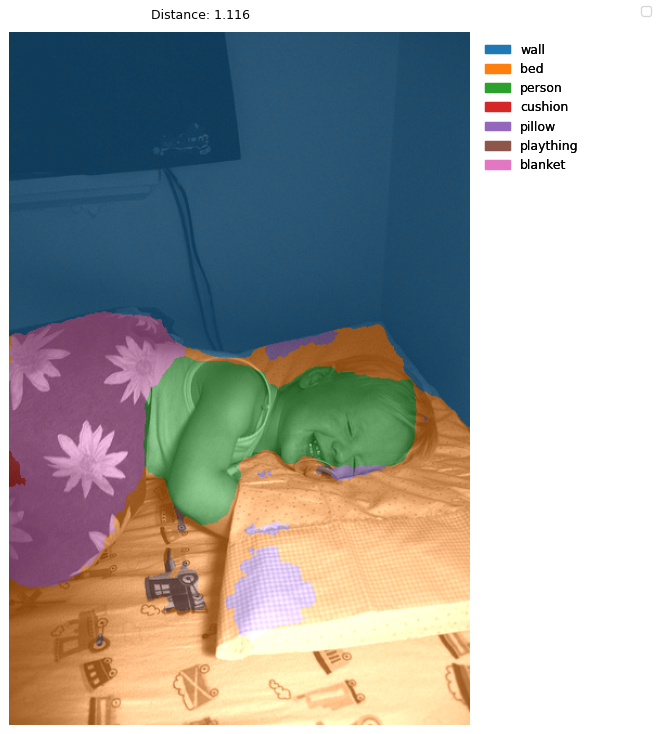

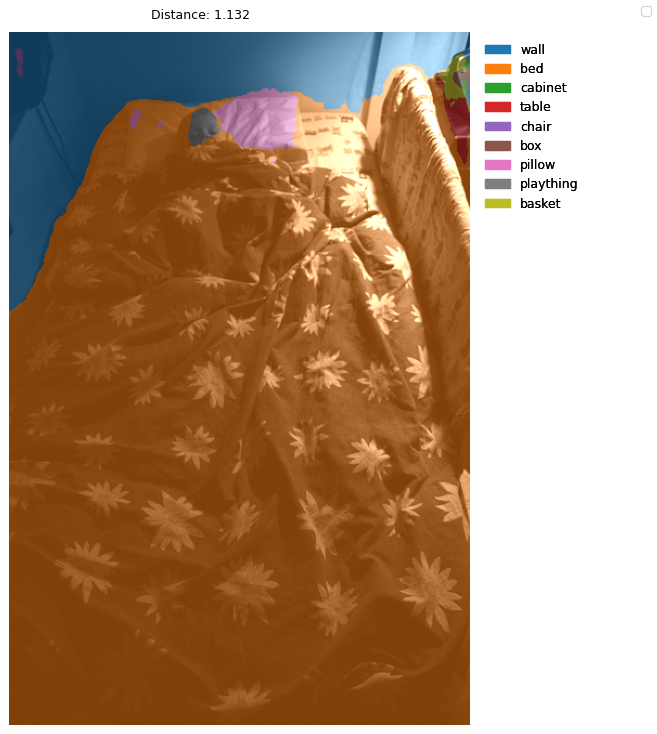

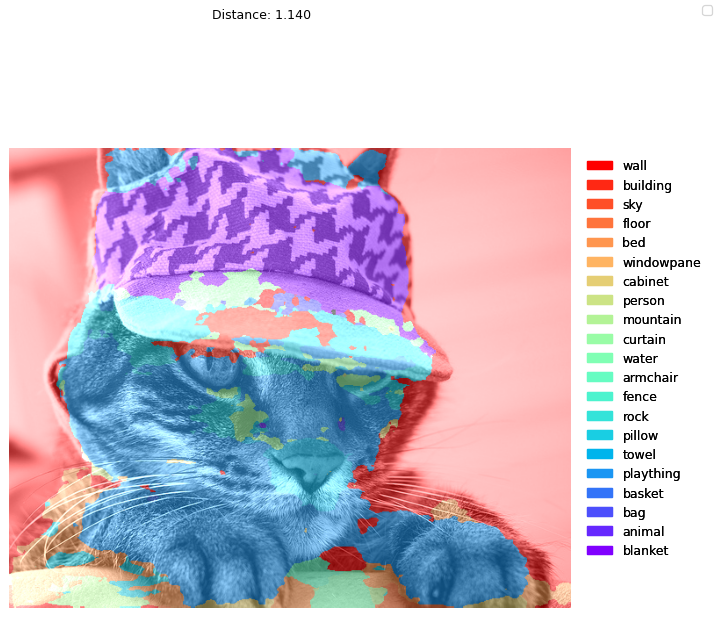

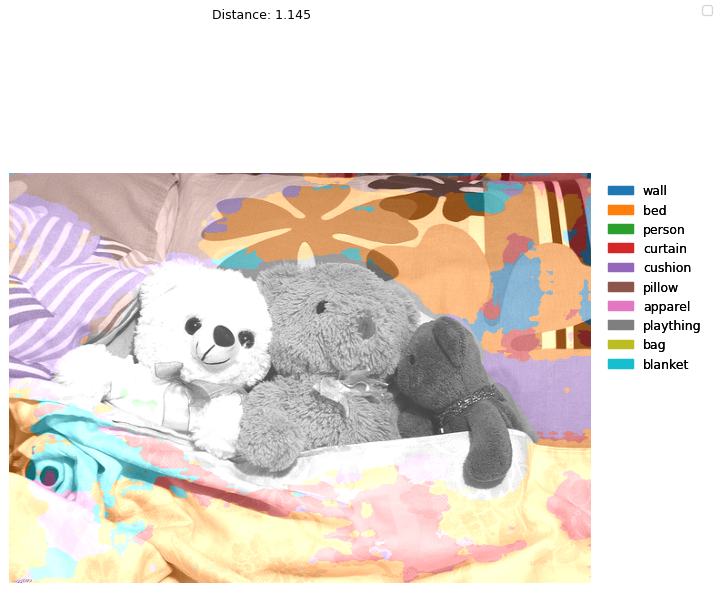

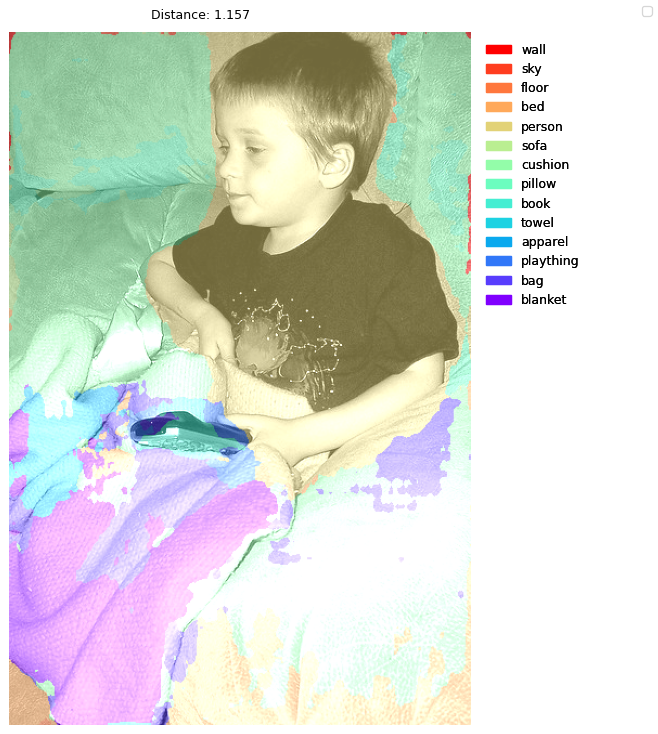

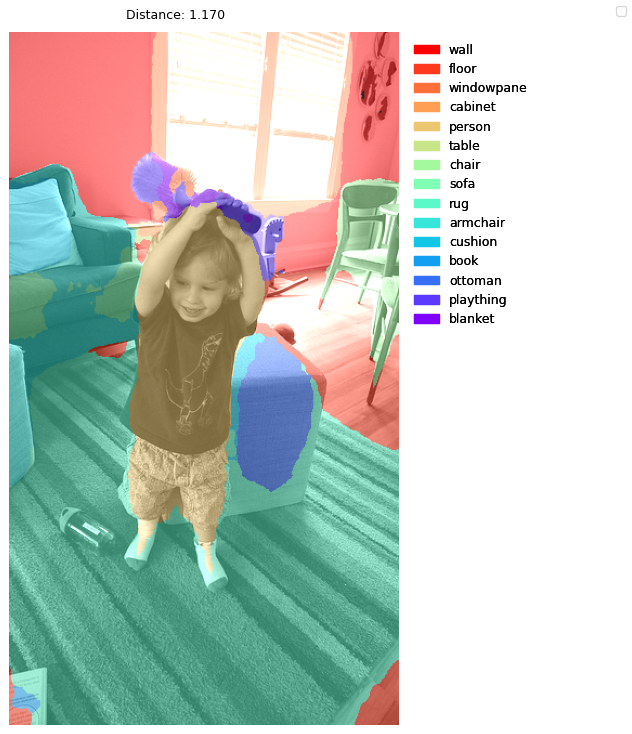

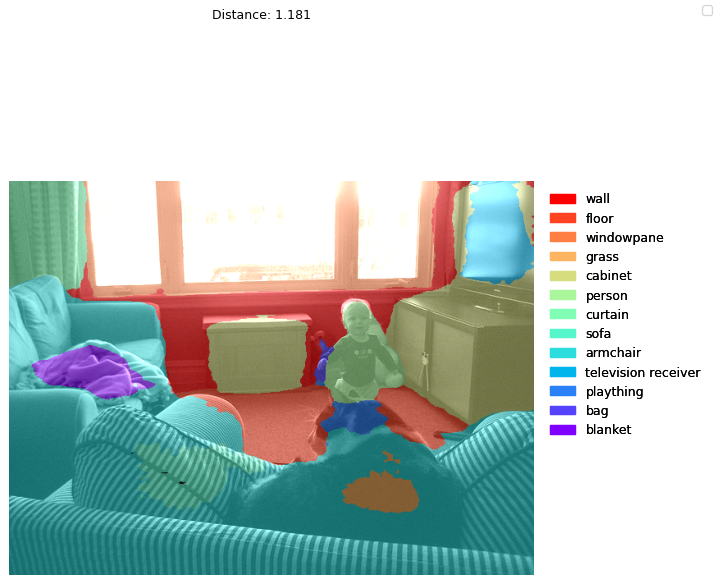

In [14]:
# Query the database

TEXT_QUERY = "a cozy cottage with lots of toys"
MAX_RESULTS = 10

from pytictoc import TicToc
from PIL import Image
import chromadb
import json
import numpy as np
from segmentation_mask_overlay import overlay_masks

with TicToc():
    chroma = chromadb.PersistentClient("tags.db")
    collection = chroma.get_collection("tagged_images")
    print("Loaded collection: ", end="")

with TicToc():
    results = collection.query(query_texts=TEXT_QUERY, n_results=MAX_RESULTS)
    print("Query: ", end="")

num_results = len(results["ids"][0])
print(f"{num_results} results found.")
if not num_results:
    exit(0)

for img_file, metadata, distance in zip(results["ids"][0], results["metadatas"][0], results["distances"][0]):
    img = Image.open(img_file)
    typed_metadata = json.loads(metadata["segmentation"])
    masks = [np.array(Image.open(obj["mask"]), dtype=np.bool_) for obj in typed_metadata]
    labels = [obj["label"] for obj in typed_metadata]

    fig = overlay_masks(np.array(img.convert("L")), np.stack(masks, -1), labels, return_type="mpl")
    fig.text(0.3, 1, f"Distance: {distance:.3f}")
    fig.legend("", fontsize="medium")